## Classification Models

- split data into train/test based on holdout dataset
- identify top features based on t-test results, with p-value threshold of < 0.10
- run classification models using: Logistic Regression, SVC, Naive Bayes, KNN, Decision Tree
- evaluate & predict with test data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# import sklearn modules 

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
path = './data files/'

In [4]:
# get datasets

df_audio = pd.read_csv('Teacher_Mindfulness_Audio_Transcript_Features_20230214.csv').drop('Mood', axis=1)

url = 'https://raw.githubusercontent.com/eycooper/capstone/main/holdout_samples_lookup.csv'
df_holdout_lookup = pd.read_csv(url)

In [5]:
# merge datasets
df = df_audio.merge(df_holdout_lookup,
                          left_on = 'ID', 
                          right_on = 'studyid')
df.drop(['studyid', '300s'], axis = 1, inplace = True)

In [6]:
df.head()

,ID,Total_Duration,Teacher_Duration,Student_Duration,Percent_Time_Teacher,Average_Speaker_Duration,Average_Teacher_Duration,Average_Student_Duration,Total_Word_Count,Teacher_Word_Count,Student_Word_Count,Teacher_Percent_Words,Total_Word_Rate,Teacher_Word_Rate,Student_Word_Rate,Total_Speaker_Line_Count,Teacher_Line_Count,Student_Line_Count,number_ of_syllables,number_of_pauses,rate_of_speech,articulation_rate,speaking_duration,original_duration,balance,f0_mean,f0_std,f0_median,f0_min,f0_max,f0_quantile25,f0_quan75,MFCC_1_Mean,MFCC_2_Mean,MFCC_3_Mean,MFCC_4_Mean,MFCC_5_Mean,MFCC_6_Mean,MFCC_7_Mean,MFCC_8_Mean,MFCC_9_Mean,MFCC_10_Mean,MFCC_11_Mean,MFCC_12_Mean,MFCC_13_Mean,MFCC_1_Var,MFCC_2_Var,MFCC_3_Var,MFCC_4_Var,MFCC_5_Var,MFCC_6_Var,MFCC_7_Var,MFCC_8_Var,MFCC_9_Var,MFCC_10_Var,MFCC_11_Var,MFCC_12_Var,MFCC_13_Var,MFCC_1_Skew,MFCC_2_Skew,MFCC_3_Skew,MFCC_4_Skew,MFCC_5_Skew,MFCC_6_Skew,MFCC_7_Skew,MFCC_8_Skew,MFCC_9_Skew,MFCC_10_Skew,MFCC_11_Skew,MFCC_12_Skew,MFCC_13_Skew,MFCC_1_Kurtosis,MFCC_2_Kurtosis,MFCC_3_Kurtosis,MFCC_4_Kurtosis,MFCC_5_Kurtosis,MFCC_6_Kurtosis,MFCC_7_Kurtosis,MFCC_8_Kurtosis,MFCC_9_Kurtosis,MFCC_10_Kurtosis,MFCC_11_Kurtosis,MFCC_12_Kurtosis,MFCC_13_Kurtosis,RMS_Mean,RMS_Max,RMS_Min,RMS_Std,Centroid_Mean,Centroid_Max,Centroid_Min,Centroid_Std,Bandwidth_Mean,Bandwidth_Max,Bandwidth_Min,Bandwidth_Std,Flatness_Mean,Flatness_Max,Flatness_Min,Flatness_Std,Zero_Crossing_Rate_Mean,Zero_Crossing_Rate_Max,Zero_Crossing_Rate_Min,Zero_Crossing_Rate_Std,Loudness_Mean,Loudness_Max,Loudness_Min,Loudness_Std,mindfulness,holdout
0,332,308.563991,141,167.563991,0.456955,9.075411,8.294118,9.856705,697,305,392,0.437590,2.258851,2.163121,2.339405,34,17,17,411,62,3.0,4,93.5,144.6,0.6,211.67,53.96,204.2,73,409,181,242,12.275767,11.248416,-11.403405,8.994111,-6.947085,3.552934,-2.149697,-13.171859,-11.721801,-13.183566,0.719455,-1.359205,2.892683,59.003330,428.052921,376.570811,480.629189,271.816805,240.442430,250.107968,218.737862,230.139384,183.706385,173.748565,163.662589,96.546882,-4.427178,-0.384546,-0.256914,0.305199,-0.266844,-0.182173,-0.167009,-0.289583,-0.229382,-0.212150,0.169246,0.047610,0.078353,24.993674,-1.021163,-0.388692,-0.197681,-0.027963,0.335898,0.345799,0.218810,0.077423,0.002506,0.748178,0.050016,0.413932,0.029641,0.234953,0.0,0.030134,1786.920458,9837.121455,0.0,1342.793978,1637.887678,4029.576143,0.0,736.167078,0.019112,1.000001,1.480000e-06,0.101342,0.106655,0.724121,0.0,0.111820,-41.060013,-12.580391,-92.580391,19.036415,1,0
1,348,309.289320,86,223.289320,0.278057,6.580624,3.739130,9.303722,698,195,503,0.279370,2.256787,2.267442,2.252683,47,23,24,255,39,3.0,5,50.5,86.0,0.6,244.32,56.67,242.1,80,421,208,278,10.869401,9.074677,-11.908164,7.795241,-7.867180,-0.395680,-6.808521,-14.854105,-5.608134,0.335741,2.010402,-11.104792,-2.374372,117.844373,443.504212,340.872066,421.846288,392.088738,269.676208,282.780823,278.891346,201.598711,184.257387,180.524235,156.742620,103.860091,-3.403572,-0.447509,-0.170911,0.054505,-0.355915,0.015943,-0.269408,-0.323910,-0.181812,0.243745,0.255444,-0.148239,-0.153220,12.028351,-0.977772,-0.562810,-0.102892,-0.054601,0.898272,0.406222,-0.280488,0.297556,0.332433,0.374174,-0.063299,0.823779,0.027384,0.194261,0.0,0.029680,1880.643307,9922.177642,0.0,1412.091525,1741.747397,4338.004791,0.0,810.380525,0.038517,1.000001,2.170000e-06,0.168635,0.102524,0.819824,0.0,0.115759,-43.753429,-14.232292,-94.232292,21.297735,1,0
2,335,313.918662,145,168.918662,0.461903,6.975970,6.590909,7.344290,1021,567,454,0.555338,3.252435,3.910345,2.687684,45,22,23,427,87,3.0,5,87.3,141.0,0.6,239.45,66.01,232.6,72,424,189,287,11.718530,5.376386,-16.785159,14.851442,-1.599988,0.735789,-0.782310,-13.534004,-5.126506,-5.123688,-7.457674,-6.685852,-0.191224,103.212547,407.618625,404.010201,325.159615,254.870539,195.726934,270.849372,262.024990,174.123677,163.250007,181.294042,127.413792,87.696152,-3.331619,-0.295017,-0.139161,0.311863,-0.106684,-0.227299,-0.159920,-0.256241,-0.193413,-0.270465,-0.238296,-0

In [7]:
# get train data for t-tests

train = df[df['holdout']==0].drop('holdout', axis=1)

### T-test on Train data

In [8]:
# Get list of all potential features in this data
feature_list = [col for col in train.columns if col not in ['ID', 'mindfulness']]

In [9]:
# Create empty df to hold t-test results
ttest_results = pd.DataFrame()

In [10]:
for feat in feature_list:
    # Separate treatment and control into separate dataframes
    # and select just this feature
    df_0 = train[train['mindfulness']==0]
    df_1 = train[train['mindfulness']==1]
    
    # Compute t test results for this feature
    temp_result = stats.ttest_ind(a = df_0[feat], 
                                  b = df_1[feat],
                                  equal_var = False)
    
    # Add t stat and p value to results df
    df_temp = pd.DataFrame({
                            'feature': feat,
                            'mean_0': df_0[feat].mean(),
                            'mean_1': df_1[feat].mean(),
                            't_statistic': temp_result[0],
                            'p_value': temp_result[1]
                            }, 
                            index = [0])
    
    ttest_results = pd.concat([ttest_results, df_temp], axis=0)

In [11]:
ttest_results.reset_index(inplace = True, drop = True)

In [12]:
# Sort by p-value to see which variables show the largest differences
ttest_results.sort_values('p_value', inplace = True)
ttest_results.head(10)

,feature,mean_0,mean_1,t_statistic,p_value
102,Zero_Crossing_Rate_Std,0.108109,0.097637,2.118993,0.038728
13,Student_Word_Rate,2.089122,2.248340,-1.987631,0.050985
95,Flatness_Mean,0.032036,0.021637,1.953778,0.054878
98,Flatness_Std,0.128044,0.093263,1.834452,0.070899
74,MFCC_5_Kurtosis,0.173829,-0.049847,1.801957,0.077136
44,MFCC_1_Var,91.280531,66.037515,1.786926,0.078417
90,Centroid_Std,1282.166986,1181.659778,1.790963,0.078511
68,MFCC_12_Skew,-0.084063,-0.002248,-1.779579,0.079560
34,MFCC_4_Mean,6.902417,4.582295,1.771954,0.081046
91,Bandwidth_Mean,1689.559720,1616.036908,1.766707,0.081711


After running a full t-test on the training data, there's only 1 statistically significant feature ZCR_Std that has a p-value less than 0.05.
In order to have a more well-rounded set of features for the model, we lowered the p-value threshold to < 0.10 - this gives us a set of 12 features for the baseline models.

In [13]:
# only the features that have a p-value < 0.10 since there's only 1 var with a p-value < 0.05

top_feats = ttest_results[ttest_results['p_value'] < 0.10]

In [14]:
# get top features into a list with ID and mindfulness

top_feats = [f for f in top_feats['feature']]
top_feats.append('ID')
top_feats.append('mindfulness')

In [15]:
# train/test sets with top features

train = train[top_feats]
test = df[df['holdout']==1].drop('holdout', axis=1)
test = test[top_feats]

In [16]:
train.shape, test.shape

((71, 14), (18, 14))

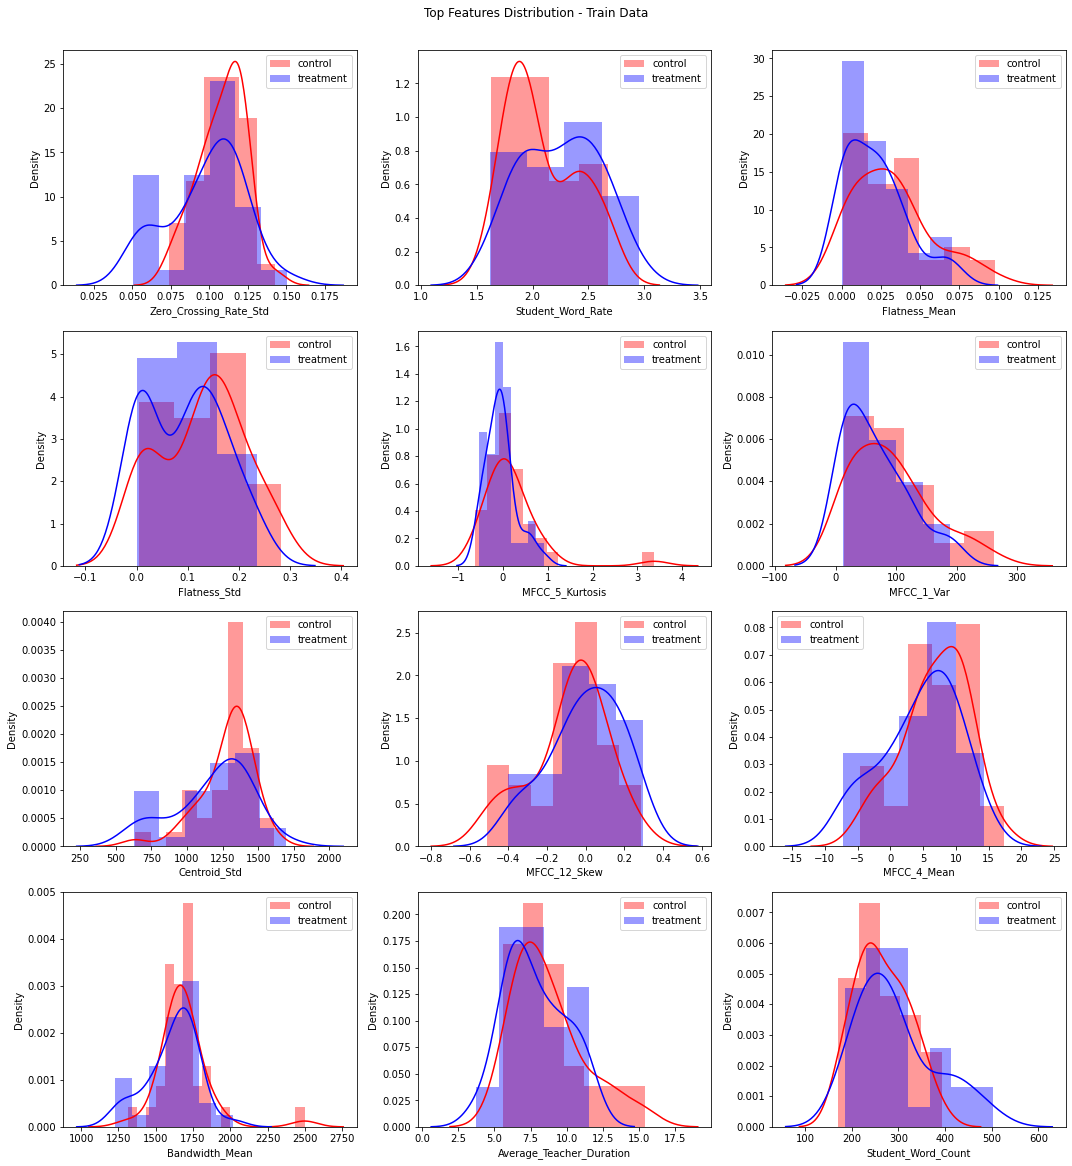

In [17]:
fig = plt.figure(figsize = (15, 20))
j = 0
for i in train.iloc[:,:-2]:
    plt.subplot(5, 3, j+1)
    j += 1
    sns.distplot(train[i][train['mindfulness']==0], color='red', label = 'control')
    sns.distplot(train[i][train['mindfulness']==1], color='blue', label = 'treatment')
    plt.legend(loc='best')
fig.suptitle('Top Features Distribution - Train Data')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

After lowering the threshold, it's clear that there is quite a bit of overlap between treatment and control groups. We'll see how well this fits the test data and whether any of the models will be precise enough to distinguish between the two. 

#### Baseline Model Comparison

In [19]:
# feature vectors & target variable

X_train = train.drop(['mindfulness', 'ID'], axis=1)
y_train = train['mindfulness']

X_test = test.drop(['mindfulness', 'ID'], axis=1)
y_test = test['mindfulness']

In [20]:
# check that split is correct 

check = [X_train.shape[0], y_train.shape[0], X_test.shape[0], y_test.shape[0]]
check

[71, 71, 18, 18]

In [21]:
# compare models 
models = []

def classification_models(X_train, y_train):
    
    models.append(('Logistic Regression', LogisticRegression() ))
    models.append( ('SVM',  SVC()) )
    models.append( ('Naive Bayes',  GaussianNB()) )
    models.append( ('KNN', KNeighborsClassifier()) )
    models.append( ('Decision Tree', DecisionTreeClassifier()))
    
    model_names = []
    model_outcomes = []
    
    for name, model in models:
        results = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        
        model_names.append(name)
        model_outcomes.append(results.mean())
        
        # print(name, results.mean())
        
        model_df = pd.DataFrame(list(zip(model_names, model_outcomes)), columns =['Models', 'Train Accuracy'])
        
    return model_df
        
    # print(model_outcomes)       
    

In [22]:
train_results = pd.DataFrame()

In [23]:
train_results = classification_models(X_train, y_train)

In [24]:
# return results for each model + training accuracy 
round(train_results, 4)

,Models,Train Accuracy
0,Logistic Regression,0.5667
1,SVM,0.5371
2,Naive Bayes,0.6638
3,KNN,0.5086
4,Decision Tree,0.5943


Baseline train results (without any hyperparameter tuning) show that Naive Bayes has the highest train accuracy.

In [25]:
# evaluation & prediction

def eval_predict_models(X_train, X_test, y_train, y_test):
    
    model_names = []
    model_outcomes = []

    for name, model in models:
        trainedmodel = model.fit(X_train, y_train)
    
        # prediction
        ypredict = trainedmodel.predict(X_test)
    
        acc = accuracy_score(y_test, ypredict)
        classreport = classification_report(y_test, ypredict)
        confMat = confusion_matrix(y_test, ypredict)
        
        model_names.append(name)
        model_outcomes.append(acc) 
        
        print('Model Type: {}'.format(name))
        print('The Classification Report:\n {}'.format(classreport))
        print('The Confusion Matrix:\n {}'.format(confMat))
        print('\n************')
    
        model_df = pd.DataFrame((model_names, model_outcomes)).T
        model_df.columns = ['Models', 'Test Accuracy']
    
    return model_df

In [26]:
test_results = pd.DataFrame()

In [27]:
test_results = eval_predict_models(X_train, X_test, y_train, y_test)

Model Type: Logistic Regression
The Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.56      0.56         9
           1       0.56      0.56      0.56         9

    accuracy                           0.56        18
   macro avg       0.56      0.56      0.56        18
weighted avg       0.56      0.56      0.56        18

The Confusion Matrix:
 [[5 4]
 [4 5]]

************
Model Type: SVM
The Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.78      0.58         9
           1       0.33      0.11      0.17         9

    accuracy                           0.44        18
   macro avg       0.40      0.44      0.38        18
weighted avg       0.40      0.44      0.38        18

The Confusion Matrix:
 [[7 2]
 [8 1]]

************
Model Type: Naive Bayes
The Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.

#### Compare Accuracy scores

In [28]:
model_results = train_results.merge(test_results, on='Models')
round(model_results, 4)

,Models,Train Accuracy,Test Accuracy
0,Logistic Regression,0.5667,0.555556
1,SVM,0.5371,0.444444
2,Naive Bayes,0.6638,0.388889
3,KNN,0.5086,0.5
4,Decision Tree,0.5943,0.388889


While Naive Bayes had the highest training accuracy, it performed the poorest on test data which may indicate that this model is overfitting the train data. Logistic Regression performed the best out of all the models though its accuracy metric didn't change between train and test data. 

One of the issues with modeling with this data is that the sample size is small so after splitting the dataset 70/30, we're only left with 18 cases for testing. This isn't sufficient enough of a sample to properly evaluate model performance. Additionally, no hyperparameter tuning was conducted on any of the models. Before considering tuning these models, we decided to chunk the dataset and use 1 min audio chunks to expand our dataset and have a greater sample size for modeling. 